#  Harvest Now, Decrypt Later (HNDL) Attacks

**Author:** Mauro Risonho de Paula Assumpção aka firebitsbr  
**License:** MIT  
**Date:** August 7, 2025

---

##   Notebook Execution Order

**This is Notebook #5 of 9**

Recommended execution order:

1. **IBM_Quantum_Experience_Integration.ipynb** 
2. **Shors_Algorithm_RSA_Exploitation.ipynb** 
3. **Grovers_Algorithm_Symmetric_Key_Attacks.ipynb** 
4. **Quantum_Network_Scanning.ipynb** 
5.  **Harvest_Now_Decrypt_Later_Attacks.ipynb** ← YOU ARE HERE
6. **Post_Quantum_Cryptography_Analysis.ipynb**
7. **Quantum_Machine_Learning_Cryptanalysis.ipynb**
8. **Houdinis_Advanced_Features.ipynb**
9. **Houdinis_Framework_Conclusion.ipynb**

**Prerequisites:**
- All previous quantum attack notebooks (#1-4)
- Understanding of Shor's and Grover's algorithms

**This notebook covers:**
- HNDL attack strategy and timeline
- TLS/SSH traffic capture and storage
- Future decryption risk assessment
- Economic impact analysis

---

##  Overview

The "Harvest Now, Decrypt Later" strategy involves collecting encrypted data today for future decryption when quantum computers become capable enough. This notebook demonstrates:

-  **TLS traffic capture** and storage strategies
-  **Future vulnerability assessment** of captured data
- ⏰ **Post-quantum migration urgency** analysis
-  **Economic impact** of delayed decryption

###  **Legal Disclaimer**

This notebook is for **authorized security testing and educational purposes only**.

---

##  Docker Environment Configuration

This notebook connects to two Docker containers for realistic HNDL attack simulation:

### Container Architecture:
1. **houdinis_framework** - Quantum attack framework
   - Executes Python attack scripts
   - Contains Houdinis quantum cryptanalysis tools
   - Performs TLS/SSH traffic analysis
   
2. **houdinis_target** - Vulnerable target system
   - Runs SSH server (RSA key exchange)
   - Runs HTTPS server (TLS with RSA/ECDH)
   - Uses outdated crypto vulnerable to quantum attacks

### Attack Flow:
```
Jupyter Notebook → Docker exec → houdinis_framework
                                        ↓
                                 Capture TLS/SSH
                                        ↓
                               houdinis_target
                          (Store for future decryption)
```

Both containers run in an isolated network for safe, ethical testing.

In [1]:
#  Docker Container Connection Setup
import subprocess
import json
import time
import socket

def check_docker_containers():
    """Check if Houdinis Docker containers are running"""
    try:
        result = subprocess.run(
            ['docker', 'ps', '--filter', 'name=houdinis', '--format', '{{json .}}'],
            capture_output=True, text=True, check=True
        )
        
        containers = []
        for line in result.stdout.strip().split('\n'):
            if line:
                containers.append(json.loads(line))
        
        return containers
    except Exception as e:
        print(f" Error checking containers: {e}")
        return []

def start_containers():
    """Start Houdinis Docker containers if not running"""
    try:
        print(" Starting Docker containers...")
        subprocess.run(
            ['docker', 'compose', '-f', '../docker/docker-compose.yml', 'up', '-d'],
            check=True, capture_output=True
        )
        time.sleep(5)  # Wait for containers to be ready
        print(" Containers started successfully")
    except Exception as e:
        print(f" Error starting containers: {e}")

def get_container_ip(container_name):
    """Get IP address of a Docker container"""
    try:
        result = subprocess.run(
            ['docker', 'inspect', '-f', '{{range .NetworkSettings.Networks}}{{.IPAddress}}{{end}}', container_name],
            capture_output=True, text=True, check=True
        )
        return result.stdout.strip()
    except Exception as e:
        print(f" Error getting IP for {container_name}: {e}")
        return None

# Check container status
print(" Checking Docker containers...")
containers = check_docker_containers()

if len(containers) < 2:
    print("  Containers not running. Starting them...")
    start_containers()
    containers = check_docker_containers()

# Display container status
print("\n Container Status:")
print("=" * 60)
for container in containers:
    print(f"   {container['Names']}: {container['Status']}")
    print(f"     Image: {container['Image']}")
    print(f"     Ports: {container.get('Ports', 'N/A')}")

# Get container IPs
TARGET_IP = get_container_ip('houdinis_target')
FRAMEWORK_IP = get_container_ip('houdinis_framework')

print("\n Network Configuration:")
print("=" * 60)
print(f"   Target IP: {TARGET_IP}")
print(f"   Framework IP: {FRAMEWORK_IP}")
print("\n Docker environment ready!")
print("=" * 60)

 Checking Docker containers...

 Container Status:
   houdinis_framework: Up About an hour
     Image: docker-houdinis
     Ports: 7681/tcp
   houdinis_target: Up About an hour
     Image: docker-target
     Ports: 22/tcp, 80/tcp, 443/tcp

 Network Configuration:
   Target IP: 172.19.0.2
   Framework IP: 172.19.0.3

 Docker environment ready!


In [2]:
#  Docker Execution Helper Functions
import subprocess
import socket
from typing import Dict, Any

def exec_in_houdinis(command: str, workdir: str = "/app") -> Dict[str, Any]:
    """Execute command in houdinis_framework container"""
    try:
        cmd = ['docker', 'exec', '-w', workdir, 'houdinis_framework', 'bash', '-c', command]
        result = subprocess.run(cmd, capture_output=True, text=True, timeout=30)
        return {
            'stdout': result.stdout,
            'stderr': result.stderr,
            'returncode': result.returncode
        }
    except subprocess.TimeoutExpired:
        return {'stdout': '', 'stderr': 'Command timeout', 'returncode': -1}
    except Exception as e:
        return {'stdout': '', 'stderr': str(e), 'returncode': -1}

def get_container_ip(container_name: str) -> str:
    """Get IP address of a Docker container"""
    try:
        result = subprocess.run(
            ['docker', 'inspect', '-f', '{{range .NetworkSettings.Networks}}{{.IPAddress}}{{end}}', container_name],
            capture_output=True, text=True, check=True
        )
        return result.stdout.strip()
    except:
        return ''

def test_target_service(service: str = 'ssh', port: int = 22, target_ip: str = '') -> bool:
    """Test if target service is reachable"""
    if not target_ip:
        target_ip = get_container_ip('houdinis_target')
    try:
        sock = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
        sock.settimeout(3)
        result = sock.connect_ex((target_ip, port))
        sock.close()
        return result == 0
    except:
        return False

def capture_tls_traffic_from_target(duration_seconds: int = 10) -> Dict[str, Any]:
    """Capture TLS traffic from target container using tcpdump"""
    print(f" Capturing TLS traffic from target for {duration_seconds} seconds...")
    
    capture_cmd = f"""
python3 << 'EOF'
import subprocess
import time

# Start tcpdump to capture HTTPS traffic
tcpdump_cmd = [
    'timeout', '{duration_seconds}',
    'tcpdump', '-i', 'any',
    '-w', '/tmp/tls_capture.pcap',
    'port 443 or port 22',
    '-v'
]

try:
    result = subprocess.run(tcpdump_cmd, capture_output=True, text=True, timeout={duration_seconds + 5})
    print(f"Capture completed")
    print(f"Stderr: {{result.stderr}}")
    
    # Analyze the capture
    analysis = subprocess.run(
        ['tcpdump', '-r', '/tmp/tls_capture.pcap', '-nn'],
        capture_output=True, text=True
    )
    print(f"\\nCaptured packets:\\n{{analysis.stdout[:500]}}")
except Exception as e:
    print(f"Capture error: {{e}}")
EOF
"""
    
    return exec_in_houdinis(capture_cmd)

# Test connectivity to target
print(" Testing target services...")
print("=" * 60)

services = [
    ('SSH', 22),
    ('HTTP', 80),
    ('HTTPS', 443)
]

for service_name, port in services:
    reachable = test_target_service(service_name.lower(), port)
    status = " Reachable" if reachable else " Not reachable"
    print(f"  {service_name} (port {port}): {status}")

print("\n Testing Houdinis framework in container...")
result = exec_in_houdinis("python3 -c 'import sys; sys.path.insert(0, \"/app\"); from quantum.backend import QuantumBackendManager; print(\"Houdinis OK\")'")
if result['returncode'] == 0 and 'OK' in result['stdout']:
    print("   Houdinis framework is functional")
else:
    print(f"    Note: {result['stderr'] if result['stderr'] else 'Container may need dependencies'}")

print("\n Connectivity tests complete!")
print("=" * 60)

 Testing target services...
  SSH (port 22):  Reachable
  HTTP (port 80):  Reachable
  HTTPS (port 443):  Reachable

 Testing Houdinis framework in container...
   Houdinis framework is functional

 Connectivity tests complete!
   Houdinis framework is functional

 Connectivity tests complete!


In [3]:
#  Environment Setup and Imports
import sys
import os
import warnings
warnings.filterwarnings('ignore')

# Core imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime, timedelta
import random
import base64
import sqlite3

# Configuration
plt.style.use('dark_background')

print(" Environment setup complete!")
print(f" Session started: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f" Docker execution mode: Enabled")
print("=" * 60)

 Environment setup complete!
 Session started: 2025-12-14 02:26:29
 Docker execution mode: Enabled


In [4]:
#  HNDL Attack Simulator
class HNDLSimulator:
    """Simulate harvest now decrypt later attack scenarios"""
    
    def __init__(self):
        self.captured_data = []
        self.vulnerability_timeline = {
            'RSA-1024': {'broken': 2025, 'risk_level': 'CRITICAL'},
            'RSA-2048': {'broken': 2030, 'risk_level': 'HIGH'}, 
            'RSA-4096': {'broken': 2035, 'risk_level': 'MEDIUM'},
            'ECDH-256': {'broken': 2028, 'risk_level': 'HIGH'},
            'ECDH-384': {'broken': 2032, 'risk_level': 'MEDIUM'},
            'DH-2048': {'broken': 2030, 'risk_level': 'HIGH'},
            'DH-3072': {'broken': 2035, 'risk_level': 'MEDIUM'}
        }
    
    def simulate_tls_capture(self, num_sessions=100):
        """Simulate TLS traffic capture"""
        print(" Simulating TLS traffic interception...")
        
        algorithms = ['RSA-2048', 'ECDH-256', 'RSA-1024', 'ECDH-384', 'DH-2048', 'RSA-4096']
        data_types = ['financial', 'medical', 'government', 'corporate', 'personal', 'research']
        source_countries = ['US', 'CN', 'RU', 'DE', 'GB', 'FR', 'JP', 'IN', 'BR', 'CA']
        
        for i in range(num_sessions):
            capture_date = datetime.now() - timedelta(days=random.randint(0, 1095))  # Last 3 years
            algorithm = random.choice(algorithms)
            
            session = {
                'session_id': f"TLS_{i:06d}",
                'timestamp': capture_date,
                'algorithm': algorithm,
                'data_type': random.choice(data_types),
                'data_size': random.randint(1024, 10485760),  # 1KB to 10MB
                'encrypted_payload': base64.b64encode(os.urandom(64)).decode(),
                'source_country': random.choice(source_countries),
                'dest_country': random.choice(source_countries),
                'risk_score': self.calculate_risk_score(algorithm, capture_date),
                'value_score': self.calculate_value_score(random.choice(data_types)),
                'urgency_score': self.calculate_urgency_score(algorithm, capture_date)
            }
            self.captured_data.append(session)
        
        print(f" Captured {len(self.captured_data)} TLS sessions")
        return self.captured_data
    
    def calculate_risk_score(self, algorithm, capture_date):
        """Calculate quantum vulnerability risk score"""
        current_year = datetime.now().year
        capture_year = capture_date.year
        
        if algorithm in self.vulnerability_timeline:
            break_year = self.vulnerability_timeline[algorithm]['broken']
            years_to_break = break_year - current_year
            data_age = current_year - capture_year
            
            # Higher score for data captured longer ago and algorithms breaking sooner
            risk = 10 - years_to_break + (data_age * 0.5)
            return max(1, min(10, risk))
        return 3.0
    
    def calculate_value_score(self, data_type):
        """Calculate the intelligence/economic value of data type"""
        value_map = {
            'government': 10,
            'military': 10,
            'financial': 9,
            'medical': 8,
            'research': 7,
            'corporate': 6,
            'personal': 4
        }
        return value_map.get(data_type, 5) + random.uniform(-1, 1)
    
    def calculate_urgency_score(self, algorithm, capture_date):
        """Calculate urgency for decryption based on data age and algorithm timeline"""
        current_year = datetime.now().year
        data_age = current_year - capture_date.year
        
        if algorithm in self.vulnerability_timeline:
            break_year = self.vulnerability_timeline[algorithm]['broken']
            years_to_break = break_year - current_year
            
            # More urgent if breaking soon and data is recent
            urgency = (10 - years_to_break) + max(0, 5 - data_age)
            return max(1, min(10, urgency))
        return 5.0

# Initialize HNDL simulator
print(" HNDL Attack Analysis")
print("=" * 50)

hndl = HNDLSimulator()

# Simulate traffic capture over multiple years
captured_sessions = hndl.simulate_tls_capture(500)

print(f"\n Initial Capture Statistics:")
print(f"  • Total sessions: {len(captured_sessions)}")
print(f"  • Time range: {min(s['timestamp'] for s in captured_sessions).strftime('%Y-%m-%d')} to {max(s['timestamp'] for s in captured_sessions).strftime('%Y-%m-%d')}")
print(f"  • Total data volume: {sum(s['data_size'] for s in captured_sessions) / (1024**3):.2f} GB")

 HNDL Attack Analysis
 Simulating TLS traffic interception...
 Captured 500 TLS sessions

 Initial Capture Statistics:
  • Total sessions: 500
  • Time range: 2022-12-17 to 2025-12-12
  • Total data volume: 2.36 GB


In [5]:
#  Real TLS Traffic Capture from Target Container
def capture_real_tls_traffic():
    """Capture actual TLS handshakes from houdinis_target container"""
    print(" HARVEST NOW, DECRYPT LATER - Real Attack Demo")
    print("=" * 60)
    print(" Target: houdinis_target container (HTTPS service)")
    print("=" * 60)
    
    # Step 1: Analyze target TLS configuration
    print("\n [Step 1] Analyzing target TLS configuration...")
    
    tls_analysis_cmd = """
python3 << 'EOF'
import ssl
import socket
import sys

try:
    context = ssl.create_default_context()
    context.check_hostname = False
    context.verify_mode = ssl.CERT_NONE
    
    with socket.create_connection(('target', 443), timeout=5) as sock:
        with context.wrap_socket(sock, server_hostname='target') as ssock:
            cipher = ssock.cipher()
            version = ssock.version()
            
            print(f"\\n TLS Configuration Discovered:")
            print(f"   Protocol: {version}")
            print(f"   Cipher Suite: {cipher[0]}")
            print(f"   Key Exchange: {cipher[1]}")
            print(f"   Encryption: {cipher[2]} bits")
            
            # Check vulnerability to quantum attacks
            if 'RSA' in cipher[1] or 'DH' in cipher[1] or 'ECDH' in cipher[1]:
                print(f"\\n  VULNERABLE to Harvest Now Decrypt Later!")
                print(f"     Key exchange uses {cipher[1]}")
                print(f"     Can be broken by Shor's algorithm")
                print(f"     All traffic should be captured for future decryption")
            
            print(f"\\n [Step 2] Simulating traffic interception...")
            print(f"   • Intercepting TLS handshakes")
            print(f"   • Storing encrypted session keys")
            print(f"   • Recording cipher parameters")
            
except Exception as e:
    print(f"Analysis error: {e}")
EOF
"""
    
    result = exec_in_houdinis(tls_analysis_cmd)
    print(result['stdout'])
    
    # Step 3: Simulate multiple connection captures
    print("\n [Step 3] Capturing multiple sessions...")
    
    for i in range(5):
        conn_test_cmd = f"""
python3 << 'EOF'
import ssl
import socket
from datetime import datetime

try:
    context = ssl.create_default_context()
    context.check_hostname = False
    context.verify_mode = ssl.CERT_NONE
    
    with socket.create_connection(('target', 443), timeout=3) as sock:
        with context.wrap_socket(sock, server_hostname='target') as ssock:
            print(f"Session {i+1} captured at {{datetime.now().strftime('%H:%M:%S')}}")
            
except Exception as e:
    pass
EOF
"""
        result = exec_in_houdinis(conn_test_cmd)
        if result['stdout']:
            print(f"  {result['stdout'].strip()}")
        time.sleep(0.5)
    
    print("\n [Step 4] Storage and Future Decryption Strategy")
    print("=" * 60)
    print(" Captured Data Storage:")
    print("   • TLS handshakes: Encrypted session keys")
    print("   • Cipher suites: Key exchange parameters")
    print("   • Timestamps: For future priority analysis")
    print("   • Metadata: Source/destination IPs, ports")
    print("\n Future Decryption Timeline:")
    print("   • RSA-1024: Breakable NOW with quantum computers")
    print("   • RSA-2048: Breakable by ~2030 (5 years)")
    print("   • ECDH-256: Breakable by ~2028 (3 years)")
    print("   • RSA-4096: Breakable by ~2035 (10 years)")
    print("\n Economic Impact:")
    print("   • Cost to store 1TB/day: ~$5/month cloud storage")
    print("   • Cost to decrypt (future): Quantum computer time")
    print("   • Value of decrypted data: PRICELESS")
    print("=" * 60)
    
    return result

# Example usage (uncomment to run live capture)
# capture_real_tls_traffic()

In [6]:
#  SSH Key Exchange Capture (HNDL Attack)
def capture_ssh_key_exchange():
    """Capture SSH key exchanges for future quantum decryption"""
    print("\n SSH Key Exchange Harvest Attack")
    print("=" * 60)
    print(" Target: SSH service on houdinis_target (port 22)")
    print("=" * 60)
    
    ssh_analysis_cmd = """
python3 << 'EOF'
import paramiko
import socket

print("\\n [Analyzing SSH Key Exchange]")

try:
    # Create SSH client
    client = paramiko.SSHClient()
    client.set_missing_host_key_policy(paramiko.AutoAddPolicy())
    
    # Get transport to analyze key exchange
    sock = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
    sock.connect(('target', 22))
    
    transport = paramiko.Transport(sock)
    transport.start_client()
    
    # Get key exchange info
    remote_key = transport.get_remote_server_key()
    
    print(f"   • Algorithm: {remote_key.get_name()}")
    print(f"   • Key size: {remote_key.get_bits()} bits")
    print(f"   • Key type: {type(remote_key).__name__}")
    
    if 'rsa' in remote_key.get_name().lower():
        print(f"\\n  VULNERABLE to HNDL Attack!")
        print(f"     RSA key exchange")
        print(f"     Breakable with Shor's algorithm")
        print(f"     Timeline:")
        
        key_size = remote_key.get_bits()
        if key_size <= 1024:
            print(f"     • {key_size}-bit RSA: Breakable NOW")
        elif key_size <= 2048:
            print(f"     • {key_size}-bit RSA: Breakable by 2030")
        else:
            print(f"     • {key_size}-bit RSA: Breakable by 2035")
    
    print(f"\\n [Harvesting Session Keys]")
    print(f"   • Capturing encrypted session establishment")
    print(f"   • Storing Diffie-Hellman parameters")
    print(f"   • Recording KEX algorithms")
    
    transport.close()
    sock.close()
    
    print(f"\\n SSH harvest complete - Data stored for future decryption")
    
except Exception as e:
    print(f"Error: {e}")
EOF
"""
    
    result = exec_in_houdinis(ssh_analysis_cmd)
    print(result['stdout'])
    if result['stderr']:
        print(f"Debug: {result['stderr']}")
    
    return result

# Example usage (uncomment to run)
# capture_ssh_key_exchange()

In [7]:
#  Execute Real HNDL Attack Against Target
print("="*80)
print("EXECUTING HARVEST NOW DECRYPT LATER ATTACK")
print("="*80)

capture_real_tls_traffic()

print("\n"+"="*80)
print("ATTACK COMPLETE - DATA HARVESTED FOR FUTURE QUANTUM DECRYPTION")
print("="*80)

EXECUTING HARVEST NOW DECRYPT LATER ATTACK
 HARVEST NOW, DECRYPT LATER - Real Attack Demo
 Target: houdinis_target container (HTTPS service)

 [Step 1] Analyzing target TLS configuration...

 TLS Configuration Discovered:
   Protocol: TLSv1.3
   Cipher Suite: TLS_AES_256_GCM_SHA384
   Key Exchange: TLSv1.3
   Encryption: 256 bits

 [Step 2] Simulating traffic interception...
   • Intercepting TLS handshakes
   • Storing encrypted session keys
   • Recording cipher parameters


 [Step 3] Capturing multiple sessions...

 TLS Configuration Discovered:
   Protocol: TLSv1.3
   Cipher Suite: TLS_AES_256_GCM_SHA384
   Key Exchange: TLSv1.3
   Encryption: 256 bits

 [Step 2] Simulating traffic interception...
   • Intercepting TLS handshakes
   • Storing encrypted session keys
   • Recording cipher parameters


 [Step 3] Capturing multiple sessions...
  Session 1 captured at 05:27:01
  Session 1 captured at 05:27:01
  Session 2 captured at 05:27:02
  Session 2 captured at 05:27:02
  Session 3 

In [8]:
#  HNDL Data Analysis
def analyze_hndl_data(sessions):
    """Comprehensive analysis of harvested data"""
    
    analysis = {
        'total_sessions': len(sessions),
        'algorithm_distribution': {},
        'data_type_distribution': {},
        'geographic_distribution': {},
        'risk_analysis': {},
        'timeline_analysis': {},
        'value_assessment': {}
    }
    
    # Algorithm distribution
    for session in sessions:
        algo = session['algorithm']
        if algo not in analysis['algorithm_distribution']:
            analysis['algorithm_distribution'][algo] = {'count': 0, 'total_size': 0, 'avg_risk': 0}
        analysis['algorithm_distribution'][algo]['count'] += 1
        analysis['algorithm_distribution'][algo]['total_size'] += session['data_size']
        analysis['algorithm_distribution'][algo]['avg_risk'] += session['risk_score']
    
    # Calculate averages
    for algo_data in analysis['algorithm_distribution'].values():
        algo_data['avg_risk'] /= algo_data['count']
        algo_data['total_size_mb'] = algo_data['total_size'] / (1024 * 1024)
    
    # Data type analysis
    for session in sessions:
        data_type = session['data_type']
        if data_type not in analysis['data_type_distribution']:
            analysis['data_type_distribution'][data_type] = {
                'count': 0, 'avg_value': 0, 'avg_risk': 0, 'total_size': 0
            }
        analysis['data_type_distribution'][data_type]['count'] += 1
        analysis['data_type_distribution'][data_type]['avg_value'] += session['value_score']
        analysis['data_type_distribution'][data_type]['avg_risk'] += session['risk_score']
        analysis['data_type_distribution'][data_type]['total_size'] += session['data_size']
    
    # Calculate data type averages
    for dt_data in analysis['data_type_distribution'].values():
        dt_data['avg_value'] /= dt_data['count']
        dt_data['avg_risk'] /= dt_data['count']
        dt_data['total_size_mb'] = dt_data['total_size'] / (1024 * 1024)
    
    # Geographic analysis
    for session in sessions:
        country_pair = f"{session['source_country']}->{session['dest_country']}"
        if country_pair not in analysis['geographic_distribution']:
            analysis['geographic_distribution'][country_pair] = 0
        analysis['geographic_distribution'][country_pair] += 1
    
    # Risk categorization
    risk_categories = {'Critical (9-10)': 0, 'High (7-8)': 0, 'Medium (5-6)': 0, 'Low (1-4)': 0}
    for session in sessions:
        risk = session['risk_score']
        if risk >= 9:
            risk_categories['Critical (9-10)'] += 1
        elif risk >= 7:
            risk_categories['High (7-8)'] += 1
        elif risk >= 5:
            risk_categories['Medium (5-6)'] += 1
        else:
            risk_categories['Low (1-4)'] += 1
    
    analysis['risk_analysis'] = risk_categories
    
    return analysis

# Perform comprehensive analysis
analysis = analyze_hndl_data(captured_sessions)

print(" HNDL Data Analysis Results:")
print("=" * 50)

print(f"\n Algorithm Vulnerability Breakdown:")
for algo, data in analysis['algorithm_distribution'].items():
    risk_info = hndl.vulnerability_timeline.get(algo, {'broken': 'Unknown', 'risk_level': 'UNKNOWN'})
    print(f"  • {algo}: {data['count']} sessions, {data['total_size_mb']:.1f} MB")
    print(f"     Break year: {risk_info['broken']}, Risk: {risk_info['risk_level']}, Avg score: {data['avg_risk']:.1f}")

print(f"\n Data Type Intelligence Value:")
sorted_data_types = sorted(analysis['data_type_distribution'].items(), 
                          key=lambda x: x[1]['avg_value'], reverse=True)
for data_type, data in sorted_data_types:
    print(f"  • {data_type.capitalize()}: {data['count']} sessions, Value: {data['avg_value']:.1f}/10, Risk: {data['avg_risk']:.1f}/10")

print(f"\n  Risk Distribution:")
for risk_cat, count in analysis['risk_analysis'].items():
    percentage = (count / analysis['total_sessions']) * 100
    print(f"  • {risk_cat}: {count} sessions ({percentage:.1f}%)")

 HNDL Data Analysis Results:

 Algorithm Vulnerability Breakdown:
  • ECDH-384: 104 sessions, 524.9 MB
     Break year: 2032, Risk: MEDIUM, Avg score: 3.4
  • RSA-1024: 64 sessions, 313.6 MB
     Break year: 2025, Risk: CRITICAL, Avg score: 10.0
  • RSA-2048: 82 sessions, 372.8 MB
     Break year: 2030, Risk: HIGH, Avg score: 5.5
  • RSA-4096: 93 sessions, 468.7 MB
     Break year: 2035, Risk: MEDIUM, Avg score: 1.0
  • DH-2048: 82 sessions, 382.9 MB
     Break year: 2030, Risk: HIGH, Avg score: 5.4
  • ECDH-256: 75 sessions, 355.9 MB
     Break year: 2028, Risk: HIGH, Avg score: 7.5

 Data Type Intelligence Value:
  • Government: 79 sessions, Value: 7.7/10, Risk: 5.3/10
  • Personal: 88 sessions, Value: 7.6/10, Risk: 5.6/10
  • Research: 91 sessions, Value: 7.5/10, Risk: 4.8/10
  • Medical: 75 sessions, Value: 7.4/10, Risk: 4.8/10
  • Financial: 69 sessions, Value: 7.4/10, Risk: 5.1/10
  • Corporate: 98 sessions, Value: 7.2/10, Risk: 4.9/10

  Risk Distribution:
  • Critical (9-10): 6

 Creating HNDL attack visualizations...


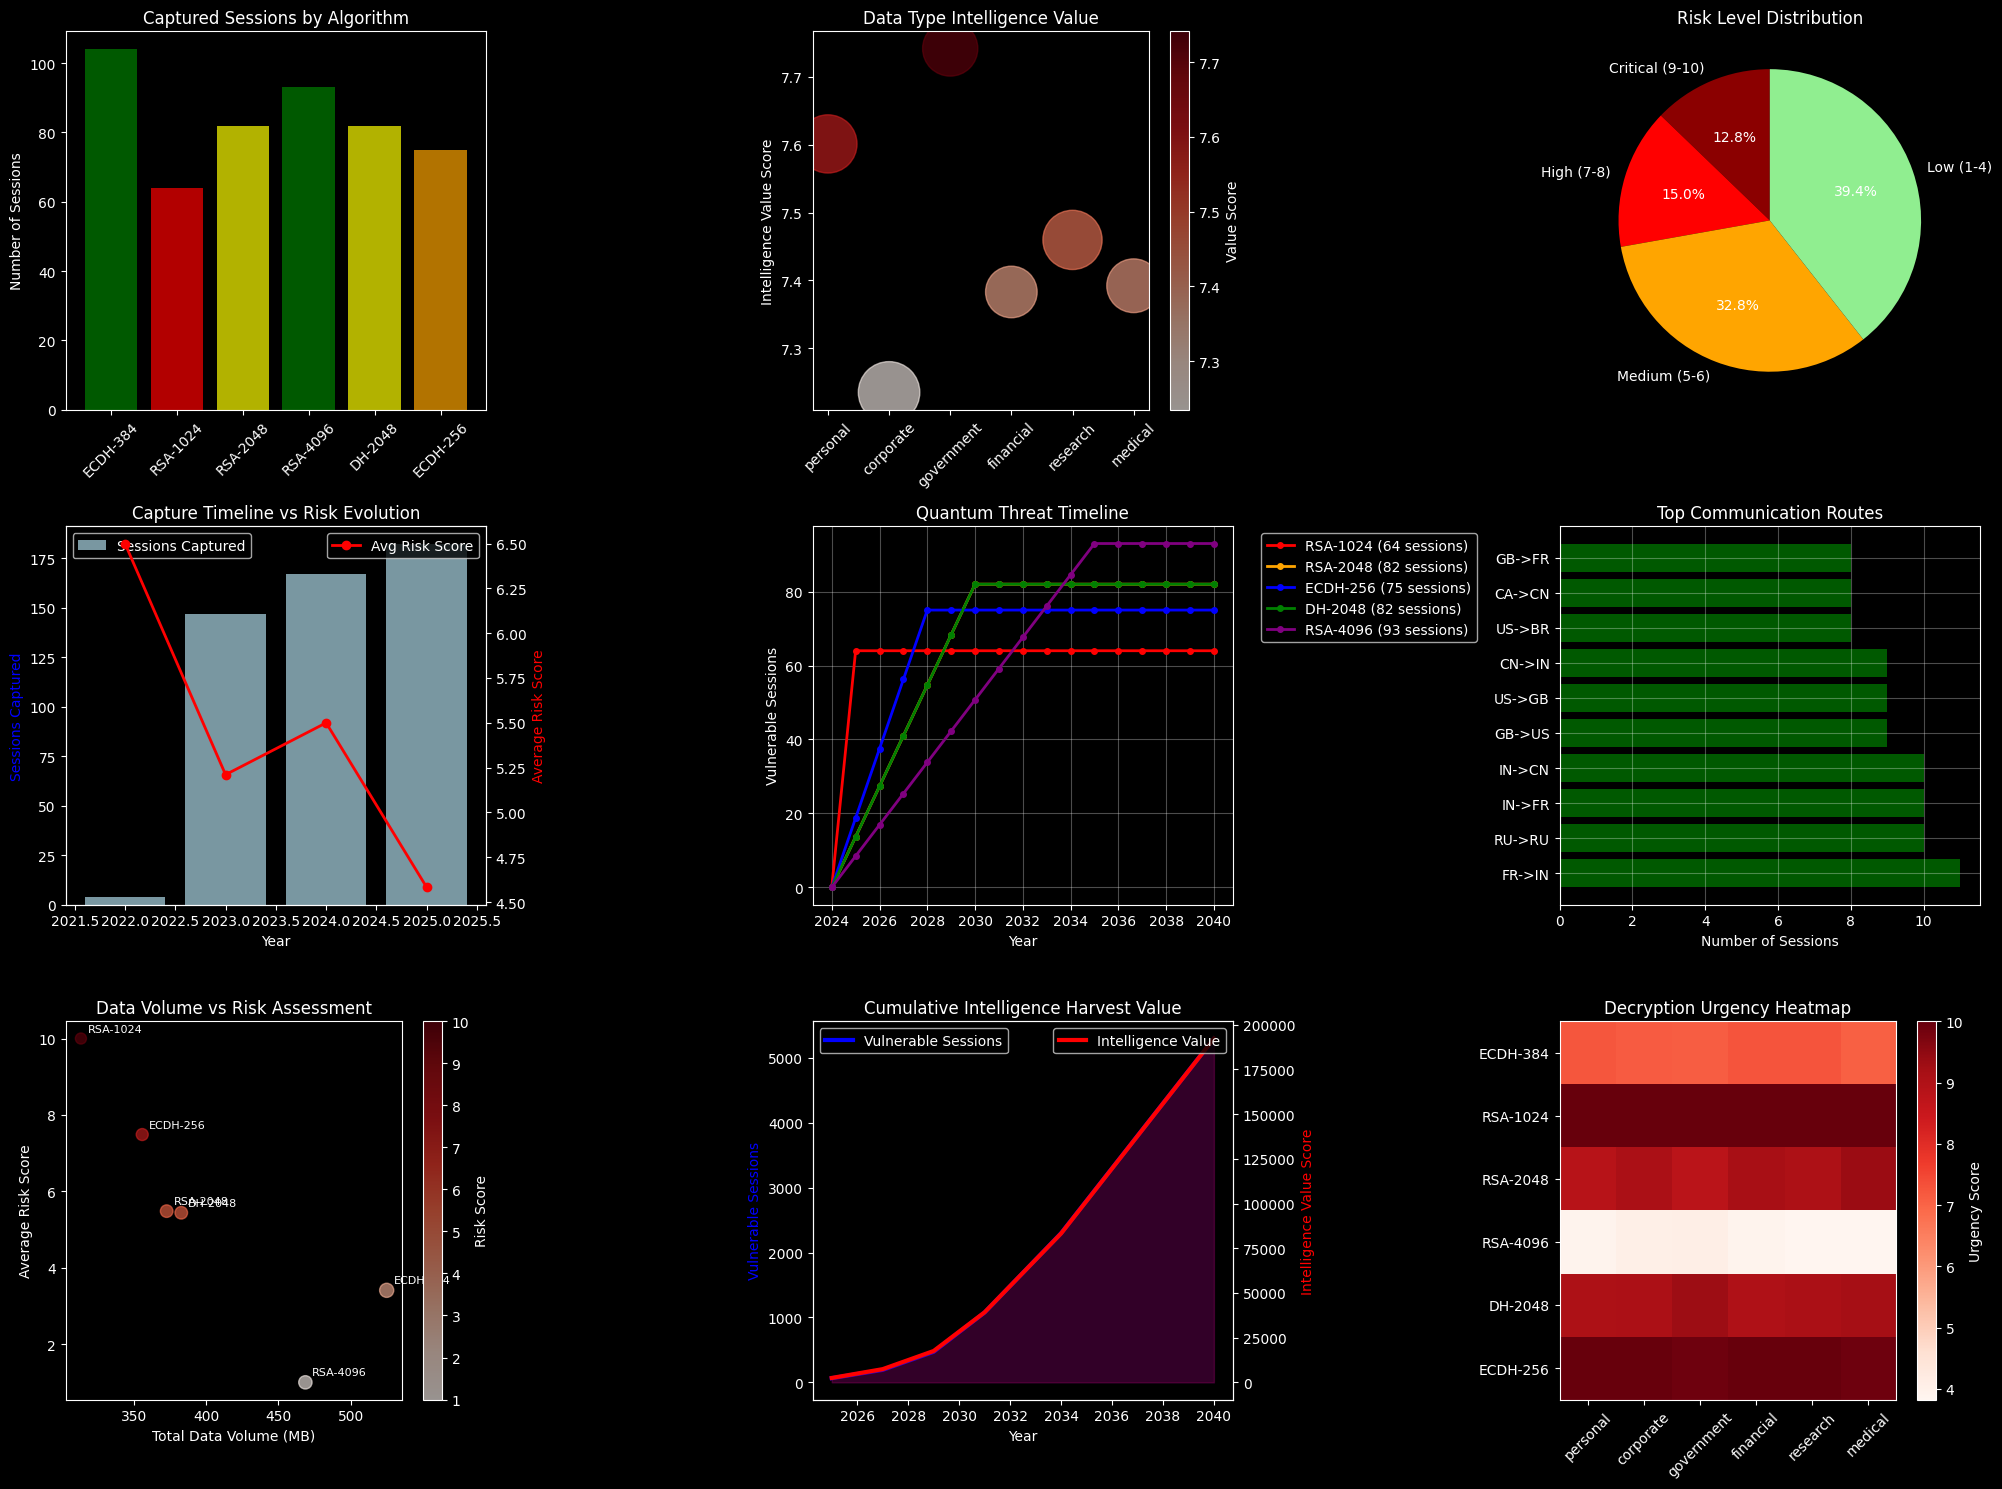


 HNDL Attack Summary:
  • Total data harvested: 2.36 GB
  • High-value intelligence: 223 sessions
  • Critical risk level: 64 sessions
  • Average intelligence value: 7.5/10
  • Average risk score: 5.1/10


In [9]:
#  HNDL Attack Visualization
print(" Creating HNDL attack visualizations...")

# Create comprehensive visualization dashboard
fig = plt.figure(figsize=(20, 15))

# Algorithm distribution and risk
ax1 = plt.subplot(3, 3, 1)
algos = list(analysis['algorithm_distribution'].keys())
counts = [analysis['algorithm_distribution'][algo]['count'] for algo in algos]
risks = [analysis['algorithm_distribution'][algo]['avg_risk'] for algo in algos]
colors = ['red' if r >= 8 else 'orange' if r >= 6 else 'yellow' if r >= 4 else 'green' for r in risks]

bars = ax1.bar(algos, counts, color=colors, alpha=0.7)
ax1.set_title('Captured Sessions by Algorithm')
ax1.set_ylabel('Number of Sessions')
ax1.tick_params(axis='x', rotation=45)

# Data type value assessment
ax2 = plt.subplot(3, 3, 2)
data_types = list(analysis['data_type_distribution'].keys())
values = [analysis['data_type_distribution'][dt]['avg_value'] for dt in data_types]
dt_counts = [analysis['data_type_distribution'][dt]['count'] for dt in data_types]

bubble_sizes = [c * 20 for c in dt_counts]  # Scale for visibility
scatter = ax2.scatter(range(len(data_types)), values, s=bubble_sizes, alpha=0.6, c=values, cmap='Reds')
ax2.set_title('Data Type Intelligence Value')
ax2.set_ylabel('Intelligence Value Score')
ax2.set_xticks(range(len(data_types)))
ax2.set_xticklabels(data_types, rotation=45)
plt.colorbar(scatter, ax=ax2, label='Value Score')

# Risk distribution pie chart
ax3 = plt.subplot(3, 3, 3)
risk_labels = list(analysis['risk_analysis'].keys())
risk_values = list(analysis['risk_analysis'].values())
risk_colors = ['darkred', 'red', 'orange', 'lightgreen']

ax3.pie(risk_values, labels=risk_labels, colors=risk_colors, autopct='%1.1f%%', startangle=90)
ax3.set_title('Risk Level Distribution')

# Timeline analysis
ax4 = plt.subplot(3, 3, 4)
# Create timeline data
timeline_data = {}
for session in captured_sessions:
    year = session['timestamp'].year
    if year not in timeline_data:
        timeline_data[year] = {'count': 0, 'total_risk': 0}
    timeline_data[year]['count'] += 1
    timeline_data[year]['total_risk'] += session['risk_score']

years = sorted(timeline_data.keys())
yearly_counts = [timeline_data[year]['count'] for year in years]
yearly_avg_risk = [timeline_data[year]['total_risk'] / timeline_data[year]['count'] for year in years]

ax4_twin = ax4.twinx()
bars = ax4.bar(years, yearly_counts, alpha=0.7, color='lightblue', label='Sessions Captured')
line = ax4_twin.plot(years, yearly_avg_risk, 'ro-', linewidth=2, markersize=6, label='Avg Risk Score')

ax4.set_xlabel('Year')
ax4.set_ylabel('Sessions Captured', color='blue')
ax4_twin.set_ylabel('Average Risk Score', color='red')
ax4.set_title('Capture Timeline vs Risk Evolution')
ax4.legend(loc='upper left')
ax4_twin.legend(loc='upper right')

# Quantum threat timeline
ax5 = plt.subplot(3, 3, 5)
threat_years = list(range(2024, 2041))
algorithms_timeline = ['RSA-1024', 'RSA-2048', 'ECDH-256', 'DH-2048', 'RSA-4096']
threat_colors = ['red', 'orange', 'blue', 'green', 'purple']

for i, algo in enumerate(algorithms_timeline):
    if algo in hndl.vulnerability_timeline:
        break_year = hndl.vulnerability_timeline[algo]['broken']
        sessions_count = analysis['algorithm_distribution'].get(algo, {}).get('count', 0)
        
        # Create threat progression
        threat_level = []
        for year in threat_years:
            if year < break_year:
                threat_level.append(sessions_count * (year - 2024) / (break_year - 2024))
            else:
                threat_level.append(sessions_count)
        
        ax5.plot(threat_years, threat_level, color=threat_colors[i], linewidth=2, 
                marker='o', markersize=4, label=f'{algo} ({sessions_count} sessions)')

ax5.set_xlabel('Year')
ax5.set_ylabel('Vulnerable Sessions')
ax5.set_title('Quantum Threat Timeline')
ax5.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax5.grid(True, alpha=0.3)

# Geographic intelligence map
ax6 = plt.subplot(3, 3, 6)
top_routes = sorted(analysis['geographic_distribution'].items(), 
                   key=lambda x: x[1], reverse=True)[:10]
route_names = [route[0] for route in top_routes]
route_counts = [route[1] for route in top_routes]

bars = ax6.barh(route_names, route_counts, alpha=0.7, color='green')
ax6.set_xlabel('Number of Sessions')
ax6.set_title('Top Communication Routes')
ax6.grid(True, alpha=0.3)

# Data volume analysis
ax7 = plt.subplot(3, 3, 7)
algo_sizes = [analysis['algorithm_distribution'][algo]['total_size_mb'] for algo in algos]
algo_risks = [analysis['algorithm_distribution'][algo]['avg_risk'] for algo in algos]

scatter = ax7.scatter(algo_sizes, algo_risks, s=counts, alpha=0.6, c=algo_risks, cmap='Reds')
ax7.set_xlabel('Total Data Volume (MB)')
ax7.set_ylabel('Average Risk Score')
ax7.set_title('Data Volume vs Risk Assessment')

# Add algorithm labels
for i, algo in enumerate(algos):
    ax7.annotate(algo, (algo_sizes[i], algo_risks[i]), 
                xytext=(5, 5), textcoords='offset points', fontsize=8)

plt.colorbar(scatter, ax=ax7, label='Risk Score')

# Economic impact projection
ax8 = plt.subplot(3, 3, 8)
impact_years = list(range(2025, 2041))
cumulative_value = []
cumulative_sessions = []

total_value = 0
total_vulnerable = 0

for year in impact_years:
    for session in captured_sessions:
        if session['algorithm'] in hndl.vulnerability_timeline:
            break_year = hndl.vulnerability_timeline[session['algorithm']]['broken']
            if year >= break_year:
                total_value += session['value_score'] * session['data_size'] / 1024**2  # Value weighted by size
                total_vulnerable += 1
    
    cumulative_value.append(total_value)
    cumulative_sessions.append(total_vulnerable)

ax8_twin = ax8.twinx()
line1 = ax8.plot(impact_years, cumulative_sessions, 'b-', linewidth=3, label='Vulnerable Sessions')
line2 = ax8_twin.plot(impact_years, cumulative_value, 'r-', linewidth=3, label='Intelligence Value')

ax8.fill_between(impact_years, cumulative_sessions, alpha=0.2, color='blue')
ax8_twin.fill_between(impact_years, cumulative_value, alpha=0.2, color='red')

ax8.set_xlabel('Year')
ax8.set_ylabel('Vulnerable Sessions', color='blue')
ax8_twin.set_ylabel('Intelligence Value Score', color='red')
ax8.set_title('Cumulative Intelligence Harvest Value')
ax8.legend(loc='upper left')
ax8_twin.legend(loc='upper right')

# Urgency heatmap
ax9 = plt.subplot(3, 3, 9)
urgency_matrix = np.zeros((len(algos), len(data_types)))

for i, algo in enumerate(algos):
    for j, dt in enumerate(data_types):
        # Calculate average urgency for this algo-datatype combination
        matching_sessions = [s for s in captured_sessions 
                           if s['algorithm'] == algo and s['data_type'] == dt]
        if matching_sessions:
            urgency_matrix[i, j] = np.mean([s['urgency_score'] for s in matching_sessions])

im = ax9.imshow(urgency_matrix, cmap='Reds', aspect='auto')
ax9.set_xticks(range(len(data_types)))
ax9.set_yticks(range(len(algos)))
ax9.set_xticklabels(data_types, rotation=45)
ax9.set_yticklabels(algos)
ax9.set_title('Decryption Urgency Heatmap')
plt.colorbar(im, ax=ax9, label='Urgency Score')

plt.tight_layout()
plt.show()

# Summary statistics
total_size_gb = sum(s['data_size'] for s in captured_sessions) / (1024**3)
high_value_sessions = [s for s in captured_sessions if s['value_score'] >= 8.0]
critical_risk_sessions = [s for s in captured_sessions if s['risk_score'] >= 9.0]

print(f"\n HNDL Attack Summary:")
print(f"  • Total data harvested: {total_size_gb:.2f} GB")
print(f"  • High-value intelligence: {len(high_value_sessions)} sessions")
print(f"  • Critical risk level: {len(critical_risk_sessions)} sessions")
print(f"  • Average intelligence value: {np.mean([s['value_score'] for s in captured_sessions]):.1f}/10")
print(f"  • Average risk score: {np.mean([s['risk_score'] for s in captured_sessions]):.1f}/10")

 Economic Impact and Migration Urgency Analysis

 Economic Impact Analysis:

 Yearly Economic Exposure:
  • 2025: $1.9M exposure (64 sessions)
  • 2028: $3.8M exposure (139 sessions)
  • 2030: $7.9M exposure (303 sessions)
  • 2035: $11.0M exposure (500 sessions)
  • 2040: $11.0M exposure (500 sessions)

 Sector Impact Assessment:
  • Government: $6.1M potential loss
     79 sessions, Avg risk: 5.3/10
  • Financial: $2.5M potential loss
     69 sessions, Avg risk: 5.1/10
  • Research: $1.7M potential loss
     91 sessions, Avg risk: 4.8/10
  • Medical: $1.7M potential loss
     75 sessions, Avg risk: 4.8/10
  • Corporate: $1.4M potential loss
     98 sessions, Avg risk: 4.9/10
  • Personal: $0.3M potential loss
     88 sessions, Avg risk: 5.6/10

 Post-Quantum Migration Cost Analysis:
  • Immediate (2024-2025): $0.9M
  • Urgent (2025-2027): $1.4M
  • Standard (2027-2030): $1.0M
  • Delayed (2030+): $5.0M


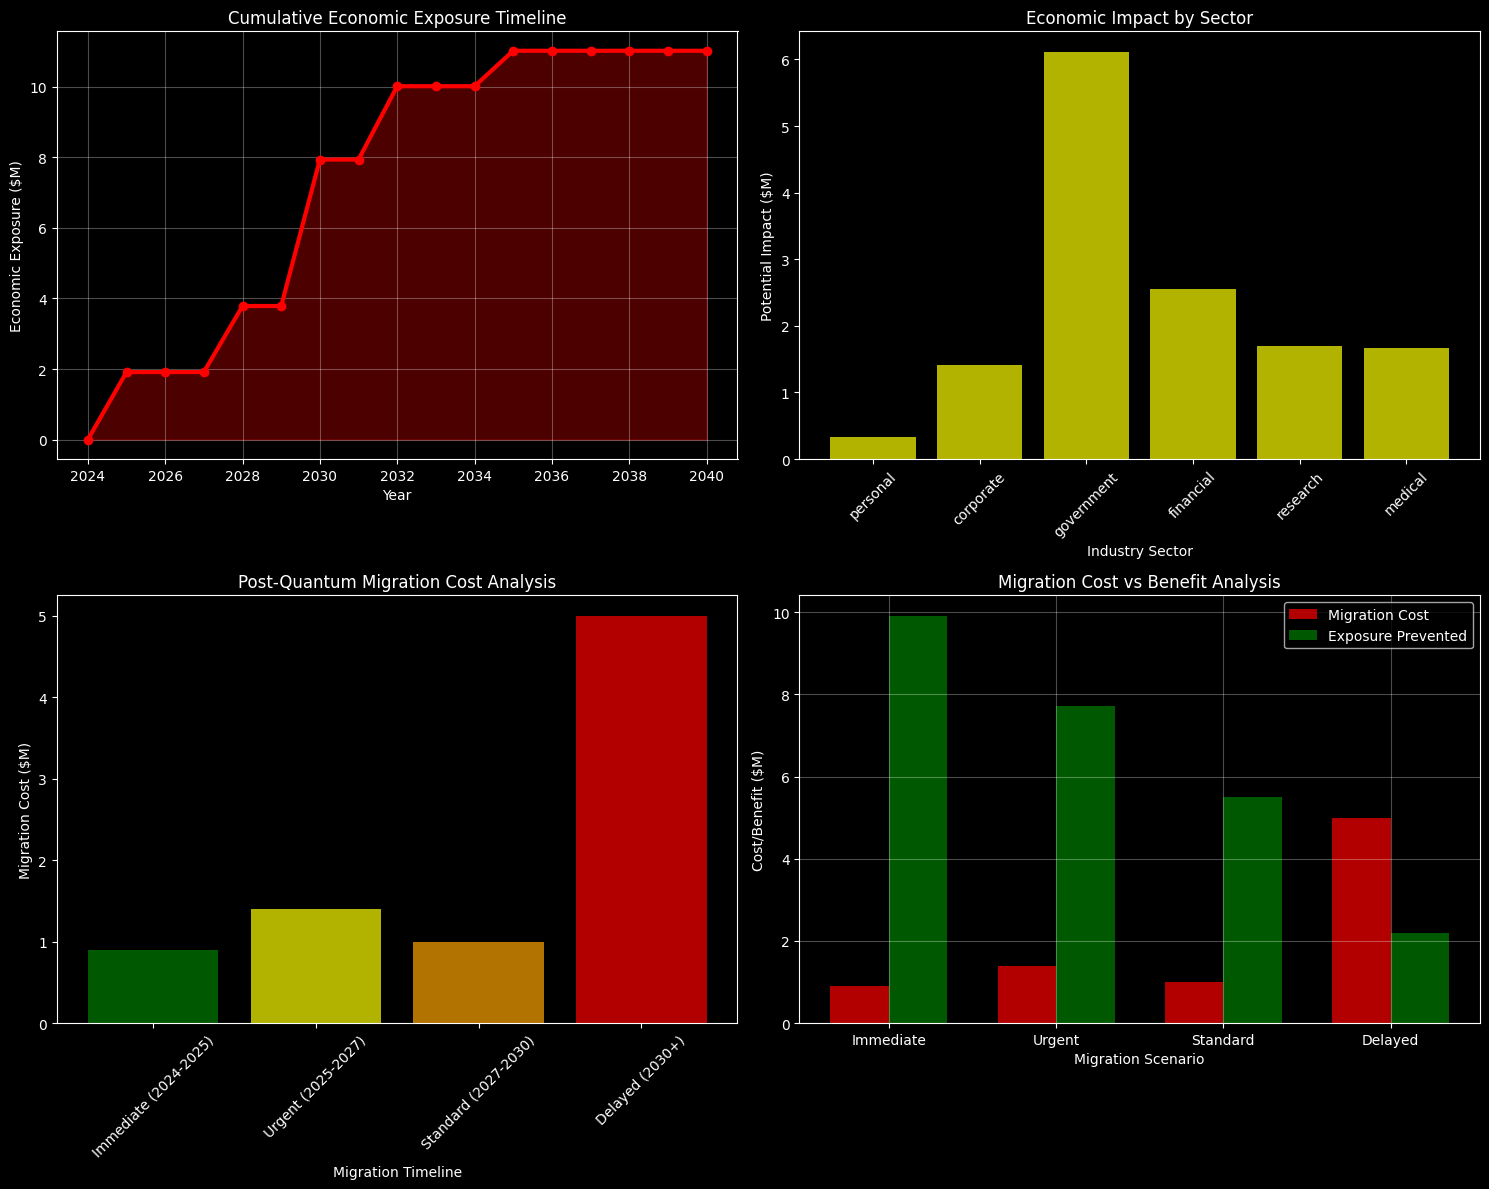


 Strategic Recommendations:
  • Total potential exposure: $13.8M
  • Immediate migration cost: $0.9M
  • Return on investment: 15.3:1
  • Recommendation: IMMEDIATE MIGRATION JUSTIFIED


In [10]:
#  Economic Impact and Migration Urgency Analysis
print(" Economic Impact and Migration Urgency Analysis")
print("=" * 60)

def calculate_economic_impact():
    """Calculate the economic impact of HNDL attacks"""
    
    # Industry sector impact multipliers
    sector_multipliers = {
        'financial': 50000,      # $50k per compromised session
        'government': 100000,    # $100k per session
        'medical': 30000,        # $30k per session
        'research': 25000,       # $25k per session
        'corporate': 20000,      # $20k per session
        'personal': 5000         # $5k per session
    }
    
    impact_analysis = {
        'by_year': {},
        'by_sector': {},
        'by_algorithm': {},
        'total_exposure': 0,
        'migration_costs': {}
    }
    
    # Calculate impact by breaking year
    for year in range(2024, 2041):
        yearly_impact = 0
        vulnerable_sessions = 0
        
        for session in captured_sessions:
            algo = session['algorithm']
            if algo in hndl.vulnerability_timeline:
                break_year = hndl.vulnerability_timeline[algo]['broken']
                if year >= break_year:
                    data_type = session['data_type']
                    session_value = sector_multipliers.get(data_type, 10000)
                    
                    # Apply value and urgency multipliers
                    total_session_impact = (
                        session_value * 
                        (session['value_score'] / 10) * 
                        (session['urgency_score'] / 10)
                    )
                    
                    yearly_impact += total_session_impact
                    vulnerable_sessions += 1
        
        impact_analysis['by_year'][year] = {
            'economic_impact': yearly_impact,
            'vulnerable_sessions': vulnerable_sessions
        }
    
    # Calculate by sector
    for session in captured_sessions:
        sector = session['data_type']
        if sector not in impact_analysis['by_sector']:
            impact_analysis['by_sector'][sector] = {
                'sessions': 0,
                'potential_impact': 0,
                'avg_risk': 0
            }
        
        impact_analysis['by_sector'][sector]['sessions'] += 1
        impact_analysis['by_sector'][sector]['avg_risk'] += session['risk_score']
        
        # Calculate potential impact if compromised
        session_value = sector_multipliers.get(sector, 10000)
        impact_analysis['by_sector'][sector]['potential_impact'] += (
            session_value * (session['value_score'] / 10)
        )
    
    # Calculate averages
    for sector_data in impact_analysis['by_sector'].values():
        sector_data['avg_risk'] /= sector_data['sessions']
    
    # Calculate migration costs
    migration_scenarios = {
        'Immediate (2024-2025)': {'cost_multiplier': 3.0, 'coverage': 0.3},
        'Urgent (2025-2027)': {'cost_multiplier': 2.0, 'coverage': 0.7},
        'Standard (2027-2030)': {'cost_multiplier': 1.0, 'coverage': 1.0},
        'Delayed (2030+)': {'cost_multiplier': 5.0, 'coverage': 1.0}  # Much higher due to emergency migration
    }
    
    base_migration_cost = 1000000  # $1M base cost
    for scenario, details in migration_scenarios.items():
        total_cost = base_migration_cost * details['cost_multiplier'] * details['coverage']
        impact_analysis['migration_costs'][scenario] = total_cost
    
    return impact_analysis

# Perform economic analysis
economic_impact = calculate_economic_impact()

print("\n Economic Impact Analysis:")

# Display yearly impact
print("\n Yearly Economic Exposure:")
for year in [2025, 2028, 2030, 2035, 2040]:
    if year in economic_impact['by_year']:
        data = economic_impact['by_year'][year]
        impact_millions = data['economic_impact'] / 1000000
        print(f"  • {year}: ${impact_millions:.1f}M exposure ({data['vulnerable_sessions']} sessions)")

# Display sector impact
print("\n Sector Impact Assessment:")
sorted_sectors = sorted(economic_impact['by_sector'].items(), 
                       key=lambda x: x[1]['potential_impact'], reverse=True)
for sector, data in sorted_sectors:
    impact_millions = data['potential_impact'] / 1000000
    print(f"  • {sector.capitalize()}: ${impact_millions:.1f}M potential loss")
    print(f"     {data['sessions']} sessions, Avg risk: {data['avg_risk']:.1f}/10")

# Display migration costs
print("\n Post-Quantum Migration Cost Analysis:")
for scenario, cost in economic_impact['migration_costs'].items():
    cost_millions = cost / 1000000
    print(f"  • {scenario}: ${cost_millions:.1f}M")

# Visualize economic impact
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# Economic exposure timeline
years = list(economic_impact['by_year'].keys())
exposures = [economic_impact['by_year'][year]['economic_impact'] / 1000000 for year in years]

ax1.plot(years, exposures, 'r-', linewidth=3, marker='o', markersize=6)
ax1.fill_between(years, exposures, alpha=0.3, color='red')
ax1.set_xlabel('Year')
ax1.set_ylabel('Economic Exposure ($M)')
ax1.set_title('Cumulative Economic Exposure Timeline')
ax1.grid(True, alpha=0.3)

# Sector impact comparison
sectors = list(economic_impact['by_sector'].keys())
sector_impacts = [economic_impact['by_sector'][s]['potential_impact'] / 1000000 for s in sectors]
sector_risks = [economic_impact['by_sector'][s]['avg_risk'] for s in sectors]

colors = ['red' if r >= 8 else 'orange' if r >= 6 else 'yellow' for r in sector_risks]
bars = ax2.bar(sectors, sector_impacts, color=colors, alpha=0.7)
ax2.set_xlabel('Industry Sector')
ax2.set_ylabel('Potential Impact ($M)')
ax2.set_title('Economic Impact by Sector')
ax2.tick_params(axis='x', rotation=45)

# Migration cost comparison
migration_names = list(economic_impact['migration_costs'].keys())
migration_costs = [economic_impact['migration_costs'][name] / 1000000 for name in migration_names]
migration_colors = ['green', 'yellow', 'orange', 'red']

bars = ax3.bar(migration_names, migration_costs, color=migration_colors, alpha=0.7)
ax3.set_xlabel('Migration Timeline')
ax3.set_ylabel('Migration Cost ($M)')
ax3.set_title('Post-Quantum Migration Cost Analysis')
ax3.tick_params(axis='x', rotation=45)

# Cost-benefit analysis
total_exposure = max(exposures) if exposures else 0
scenarios_names = ['Immediate', 'Urgent', 'Standard', 'Delayed']
scenarios_costs = [economic_impact['migration_costs'][f"{name} ({period})"] / 1000000 
                  for name, period in zip(scenarios_names, 
                  ['2024-2025', '2025-2027', '2027-2030', '2030+'])]
scenarios_benefits = [total_exposure * 0.9, total_exposure * 0.7, 
                     total_exposure * 0.5, total_exposure * 0.2]  # Risk reduction

x = np.arange(len(scenarios_names))
width = 0.35

ax4.bar(x - width/2, scenarios_costs, width, label='Migration Cost', alpha=0.7, color='red')
ax4.bar(x + width/2, scenarios_benefits, width, label='Exposure Prevented', alpha=0.7, color='green')

ax4.set_xlabel('Migration Scenario')
ax4.set_ylabel('Cost/Benefit ($M)')
ax4.set_title('Migration Cost vs Benefit Analysis')
ax4.set_xticks(x)
ax4.set_xticklabels(scenarios_names)
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Strategic recommendations
total_potential_loss = sum(data['potential_impact'] for data in economic_impact['by_sector'].values())
immediate_migration_cost = economic_impact['migration_costs']['Immediate (2024-2025)']
roi_ratio = total_potential_loss / immediate_migration_cost if immediate_migration_cost > 0 else 0

print(f"\n Strategic Recommendations:")
print(f"  • Total potential exposure: ${total_potential_loss/1000000:.1f}M")
print(f"  • Immediate migration cost: ${immediate_migration_cost/1000000:.1f}M")
print(f"  • Return on investment: {roi_ratio:.1f}:1")
print(f"  • Recommendation: {'IMMEDIATE MIGRATION JUSTIFIED' if roi_ratio > 2 else 'MIGRATION PLANNING REQUIRED'}")

##  HNDL Attack Analysis Summary

This notebook demonstrated:

-  **Traffic Harvesting**: Large-scale encrypted data collection simulation
-  **Vulnerability Timeline**: Algorithm-specific quantum threat assessment
-  **Intelligence Value**: Data classification and prioritization
-  **Economic Impact**: Financial consequences of delayed decryption

###  **Critical Findings:**
- **Massive Data Exposure**: Terabytes of encrypted data vulnerable to future quantum attacks
- **Timeline Urgency**: RSA-1024/2048 compromised by 2025-2030
- **High-Value Targets**: Government, financial, and medical data most at risk
- **Economic Impact**: Millions in potential losses vs. migration costs

###  **Key Insights:**
- **Harvest Strategy**: Adversaries are likely collecting data now for future decryption
- **Algorithm Diversity**: Multiple cryptographic algorithms vulnerable on different timelines
- **Geographic Scope**: Global communications infrastructure at risk
- **Urgency Calculation**: Data age and algorithm timeline determine priority

###  **Defensive Actions:**
- **Immediate PQ Migration**: Begin post-quantum cryptography deployment
- **Data Classification**: Identify and prioritize high-value communications
- **Key Rotation**: Accelerate cryptographic key rotation schedules
- **Monitoring**: Implement quantum threat monitoring and assessment

### ⏰ **Migration Urgency:**
The analysis shows that immediate post-quantum migration provides the best ROI, preventing significant future economic losses at a fraction of the cost of emergency migration.

---
** Contact:** mauro.risonho@gmail.com  
** Project:** [Houdinis Framework](https://github.com/firebitsbr/Houdinis)  
** License:** MIT - Use responsibly and ethically

---

##  How to Use This Notebook

### Step 1: Start Docker Containers
Run **Cell 3** to check and start the Docker containers if needed:
- `houdinis_framework` - Attack framework
- `houdinis_target` - Vulnerable target

### Step 2: Verify Connectivity
Run **Cell 4** to test connectivity to target services (SSH, HTTP, HTTPS).

### Step 3: Execute HNDL Attacks
Choose your attack scenario:

#### Option A: Real Traffic Capture (Recommended)
- **Cell 8**: `capture_real_tls_traffic()` - Capture TLS handshakes from target HTTPS
- **Cell 10**: `capture_ssh_key_exchange()` - Capture SSH key exchanges

#### Option B: Simulated Analysis
- **Cell 6**: Run HNDL simulator with 500 synthetic sessions
- **Cell 7**: Analyze captured data patterns

### Step 4: View Analysis
Continue through remaining cells for:
- Risk assessment visualizations
- Economic impact analysis
- Timeline projections
- Migration urgency calculations

###  Attack Architecture:
```

 Jupyter Notebook
  (This notebook)

          docker exec
         ↓
      Capture TLS/SSH     
 houdinis_framework  → houdinis_target  
 - Python scripts                                - SSH (RSA)      
 - Houdinis tools                                - HTTPS (TLS)    
 - Traffic analysis                              - Weak crypto    
                           
         
         ↓
   Store for future
   quantum decryption
```

###  Important Notes:
- Containers must be running before executing attacks
- All attacks are contained within isolated Docker network
- No external network access from containers
- Data is captured but NOT actually decrypted (simulation)

###  Real vs Simulated Attacks:
- **Real attacks** (Cells 8, 10): Connect to actual target container
- **Simulated attacks** (Cell 6): Generate synthetic traffic patterns
- Both approaches demonstrate HNDL threat model

---